# Import de libs

Provavelmente não precisa de todas (forkado do script pra rodar na webcam)

In [12]:
import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as ipd
import numpy as np
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
from tensorflow.keras import applications
from tensorflow.keras.layers import Input
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json

from tqdm import tqdm_notebook

In [13]:
# Setando o uso da gpu pelo DLIB (se não tiver, so comentar a linha)
dlib.DLIB_USE_CUDA = True
# Definindo a size da imagem (Que por default é 100 pois foi a dimensão que o modelo foi treinado)
size = 100

In [14]:
def map_keras_label(x):
    if(x == 0):
        # Negativos são 0
        return 'negativo'
    elif(x == 1):
        # Neutros são 1
        return 'neutro'
    elif(x==2):
        # Positivos são 2
        return 'positivo'
    else:
        # Surprise é 3, aplicável nos modelos primordiais
        return 'surpresa'

In [15]:
# Carregando o modelo e os pesos da rede

# Lendo o json da arquitetura do modelo utilizado
json_file = open('model.json', 'r')

loaded_model_json = json_file.read()

json_file.close()

# Setando o modelo, backend Keras, com o json
loaded_model = model_from_json(loaded_model_json)

# Carregando os pesos salvos (Verificar o caminho do arquivo .h5)
loaded_model.load_weights("model.h5")
 
# Compilando o modelo
loaded_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Setando o nome para "model"
model = loaded_model

print("Modelo Carregado")

Modelo Carregado


In [16]:
# Função para determinar as posições do retângulo do reconhecimento facial
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [17]:
# Definindo os modelos do DLIB (as landmarks não estão sendo utilizadas mais)
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [18]:
# Lendo uma imagem que você queira predizer
imagem = cv2.imread('perfil.jpg')

In [19]:
## Preprocessando a imagem e predizendo
# Vale lembrar que não aplicamos o modelo na imagem toda, somente no retângulo reconhecido como o rosto da pessoa

rects = detector(imagem, 0)

# O loop percorre todas as faces detectadas
for k,d in enumerate(rects):

    (x, y, w, h) = rect_to_bb(d)
    
    # Preprocessamento
    face = imagem[y - 50 :y + h + 30, x - 20:x + w + 20]
    face = cv2.resize(cv2.cvtColor(face , cv2.COLOR_BGR2RGB), (size,size))
    face = np.expand_dims(np.array(face, dtype=np.float), axis=0)
    preds = model.predict(face)
    # Print preds onde a primeira posição é o negativo, o segundo é o neutro e o terceiro o positivo
    print(preds[0])
    print(map_keras_label(np.argmax(preds[0])))


    cv2.rectangle(imagem, (x - 20, y - 50), (x + 20 + w, y + 20 +  h), (0, 255, 0), 2)
    cv2.putText(imagem, map_keras_label(np.argmax(preds[0])), (x+5, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (50, 255, 50), 2, cv2.LINE_AA)

[5.7287572e-30 2.8054868e-32 1.0000000e+00]
positivo


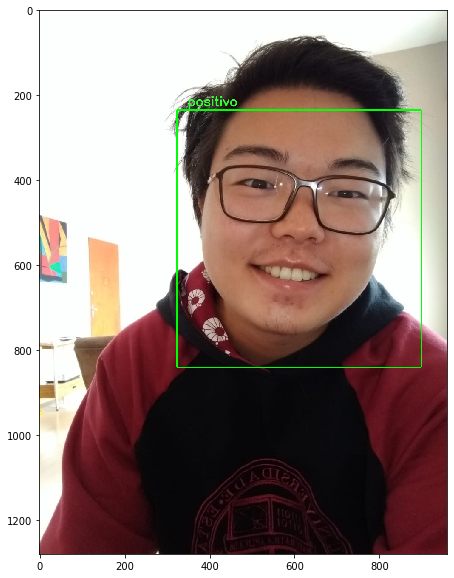

In [20]:
# Plota a imagem com a box e o reconhecimento
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(imagem)